# Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations

>  In this first part, we demonstrate how these networks can be used to infer solutions to partial differential equations, and obtain physics-informed surrogate models that are fully differentiable with respect to all input coordinates and free parameters.

In the paper, the authors explore equations of the form : 
$$u_t + \mathcal{N}[u;\lambda] = 0$$
where $u(t,x)$ is the latent (hidden) solution and $\mathcal{N}[\cdot;\lambda]$ is a nonlinear operator parametrized by $\lambda$. 

As a side experiment I explore the heat equation : 

$$u_t - c^2 u_{xx} = 0$$ 
along with Dirichlet boundary conditions :
$$\begin{align*}
c = 1,\quad x \in [0, L = 1], t \in [0, 1]\\
u(0, x) &= sin(\pi x)\\
u(t, 0) &= u(t, L) = 0 
\end{align*}$$

If I want to try PINN on the heat equation, it's because I'm able to obtain the analytical solution. In practice, it's quite simple with a little knowledge of PDE solving to use the separation of variables method and find :
$$
\begin{align*}
u(x, t) &= \sum_{n=1}^\infty b_n e^{-\lambda_n^2 t}sin(\mu_n x)\\
\text{with } \lambda_n^2 &= \left(\dfrac{c n \pi}{L}\right)^2\\
\text{with } \mu_n &= \dfrac{n \pi}{L}\\
\text{with, assuming $f(x) = u(x, t = 0)$ } b_n &= \dfrac{2}{L} \int_0^L f(x) sin(\dfrac{n\pi x}{L}) dx
\end{align*}
$$

Assuming our initial condition, I can express that : 

$$
\begin{align*}
u(x, t) &=  \left.e^{-\lambda_n^2 t}sin(\mu_n x)\right|_{n = 1} = e^{-\pi^2 t} sin(\pi x)\\
\text{with } \lambda_n^2 &= \left(n \pi\right)^2\\
\text{with } \mu_n &= n \pi\\
\end{align*}
$$

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random

seed = 14
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

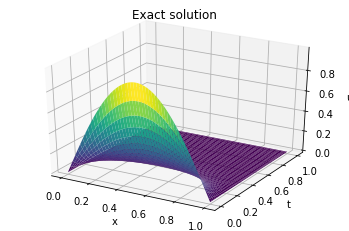

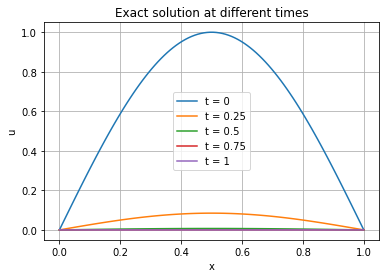

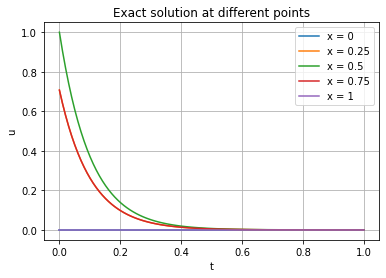

In [2]:
"""Here I define the exact solution in order to generate some data and to make some plots and accuracy calculations"""

def heat_eqn_exact_solution(x, t):
    return np.sin(np.pi*x)*np.exp(-np.pi**2*t)

res = 100
x = np.linspace(0, 1, res)
t = np.linspace(0, 1, res)
X, T = np.meshgrid(x, t)
U = heat_eqn_exact_solution(X, T)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('Exact solution')
plt.show()

#make some slice of the exact solution at t = 0, t = 0.25, t = 0.5, t = 0.75, t = 1

def get_solution_along_t(t):
    x = np.linspace(0, 1, res)
    return x, heat_eqn_exact_solution(x, t)

x_t_0, u_t_0 = get_solution_along_t(0)
x_t_025, u_t_025 = get_solution_along_t(0.25)
x_t_05, u_t_05 = get_solution_along_t(0.5)
x_t_075, u_t_075 = get_solution_along_t(0.75)
x_t_1, u_t_1 = get_solution_along_t(1)

plt.figure()
plt.plot(x_t_0, u_t_0, label='t = 0')
plt.plot(x_t_025, u_t_025, label='t = 0.25')
plt.plot(x_t_05, u_t_05, label='t = 0.5')
plt.plot(x_t_075, u_t_075, label='t = 0.75')
plt.plot(x_t_1, u_t_1, label='t = 1')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.title('Exact solution at different times')
plt.grid()
plt.show()

# make some slice of the exact solution at x = 0, x = 0.25, x = 0.5, x = 0.75, x = 1

def get_solution_along_x(x):
    t = np.linspace(0, 1, res)
    return t, heat_eqn_exact_solution(x, t)

t_x_0, u_x_0 = get_solution_along_x(0)
t_x_025, u_x_025 = get_solution_along_x(0.25)
t_x_05, u_x_05 = get_solution_along_x(0.5)
t_x_075, u_x_075 = get_solution_along_x(0.75)
t_x_1, u_x_1 = get_solution_along_x(1)

plt.figure()
plt.plot(t_x_0, u_x_0, label='x = 0')
plt.plot(t_x_025, u_x_025, label='x = 0.25')
plt.plot(t_x_05, u_x_05, label='x = 0.5')
plt.plot(t_x_075, u_x_075, label='x = 0.75')
plt.plot(t_x_1, u_x_1, label='x = 1')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.title('Exact solution at different points')
plt.grid()
plt.show()


In [3]:
class HeatEqquation1D:
    def __init__(self, c):
        self.c = c

    #should return the residual of the PDE
    def __call__(self, u, x, t):
        torch.autograd.set_detect_anomaly(True)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        return u_t - self.c**2 * u_xx


class PhysicsInformedNeuralNetwork(nn.Module):
    def __init__(self, equation, solver):
        super(PhysicsInformedNeuralNetwork, self).__init__()
        self.equation = equation
        self.solver = solver

    def forward(self, x, t):
        #require grad
        x_c = x.clone().detach().requires_grad_(True)
        t_c = t.clone().detach().requires_grad_(True)
        
        u = self.solver(x_c, t_c)
        residual = self.equation(u, x_c, t_c)
        return u, residual
    
# u_pred and u_target are the initial and boundary conditions
# residual is the residual of the PDE at the collocation points
# usually N_u is small and that's why we want to use a PINN to enrich the data information content
def loss_fn(u_pred, u_target, residual):
    return torch.mean((u_pred - u_target)**2) + torch.mean(residual**2)

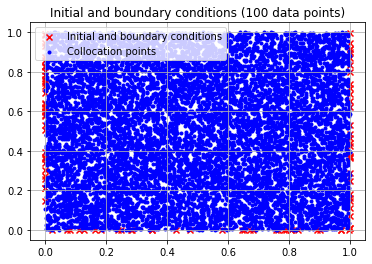

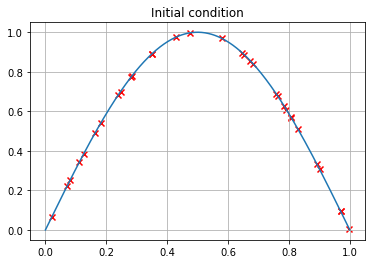

In [4]:
N_u = 100
N_f = 10000
x_space_range = [0, 1]
t_space_range = [0, 1]

#initial condition
def u_0(x):
    return torch.sin(np.pi * x)

#boundary condition
def u_L(t):
    return torch.zeros_like(t)

def u_R(t):
    return torch.zeros_like(t)

def generate_data_points(N_u, N_f, x_space_range, t_space_range):
    left_x = torch.tensor([x_space_range[0]]).repeat(N_u, 1)
    left_t = torch.rand(N_u, 1) * (t_space_range[1] - t_space_range[0]) + t_space_range[0]
    left = torch.cat((left_x, left_t), 1)
    left_u = u_L(left_x)

    right_x = torch.tensor([x_space_range[1]]).repeat(N_u, 1)
    right_t = torch.rand(N_u, 1) * (t_space_range[1] - t_space_range[0]) + t_space_range[0]
    right = torch.cat((right_x, right_t), 1)
    right_u = u_R(right_x)

    initial_x = torch.rand(N_u, 1) * (x_space_range[1] - x_space_range[0]) + x_space_range[0]
    initial_t = torch.zeros(N_u, 1)
    initial = torch.cat((initial_x, initial_t), 1)
    initial_u = u_0(initial_x)

    left_points = torch.cat((left, left_u), 1)
    right_points = torch.cat((right, right_u), 1)
    initial_points = torch.cat((initial, initial_u), 1)

    points = torch.cat((left_points, right_points, initial_points), 0)
    #shuffle the points
    points = points[torch.randperm(points.size()[0])]

    x_N_f = torch.rand(N_f, 1) * (x_space_range[1] - x_space_range[0]) + x_space_range[0]
    t_N_f = torch.rand(N_f, 1) * (t_space_range[1] - t_space_range[0]) + t_space_range[0]

    points_N_f = torch.cat((x_N_f, t_N_f), 1)

    return points[:N_u], points_N_f

N_u_points, N_f_points = generate_data_points(N_u, N_f, x_space_range, t_space_range)

#make a plot with crosses for the initial and boundary conditions
plt.title(f'Initial and boundary conditions ({N_u_points.shape[0]} data points)')
plt.scatter(N_u_points[:, 0], N_u_points[:, 1], marker='x', color='red')
plt.scatter(N_f_points[:, 0], N_f_points[:, 1], marker='.', color='blue')
plt.legend(['Initial and boundary conditions', 'Collocation points'])
plt.grid()
plt.show()

# make a plot of the initial condition
x = torch.linspace(x_space_range[0], x_space_range[1], 1000).reshape(-1, 1)
plt.title('Initial condition')
plt.plot(x, u_0(x))
plt.scatter(N_u_points[N_u_points[:, 1] == 0][:, 0], N_u_points[N_u_points[:, 1] == 0][:, 2], marker='x', color='red')
plt.grid()
plt.show()


In [5]:
class SimpleSolver(nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(SimpleSolver, self).__init__()
        layers = [nn.Linear(2, n_neurons), nn.Tanh()]
        for _ in range(n_layers - 2):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(n_neurons, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        X = torch.cat((x, t), 1)
        return self.net(X)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

c = 1

equation = HeatEqquation1D(c)
n_layers = 5
n_neurons = 50
net = SimpleSolver(n_layers, n_neurons)
print("Number of parameters :", sum(p.numel() for p in net.parameters() if p.requires_grad))

pinn = PhysicsInformedNeuralNetwork(equation, net)
pinn.to(device)

cuda
Number of parameters : 7851


PhysicsInformedNeuralNetwork(
  (solver): SimpleSolver(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): Tanh()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): Tanh()
      (6): Linear(in_features=50, out_features=50, bias=True)
      (7): Tanh()
      (8): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

In [6]:
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
batch_size = N_f

path_to_save = 'heat_model.pth'

#training loop
n_epochs = 10000

for epoch in range(n_epochs):
    #generate a batch of data
    u_target = N_u_points[:, 2].reshape(-1, 1)
    x_u = N_u_points[:, 0].reshape(-1, 1)
    t_u = N_u_points[:, 1].reshape(-1, 1)

    idx_f = torch.randperm(N_f_points.shape[0])[:batch_size]
    x_f = N_f_points[idx_f, 0].reshape(-1, 1)
    t_f = N_f_points[idx_f, 1].reshape(-1, 1)

    x_u = x_u.to(device)
    t_u = t_u.to(device)
    u_target = u_target.to(device)
    x_f = x_f.to(device)
    t_f = t_f.to(device)

    optimizer.zero_grad()
    u_pred, _ = pinn(x_u, t_u)
    _, residual = pinn(x_f, t_f)
    loss = loss_fn(u_pred, u_target.to(device), residual)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch} - Loss: {loss.item()}')
        torch.save(pinn.state_dict(), path_to_save)

Epoch 0 - Loss: 0.19154015183448792
Epoch 100 - Loss: 0.04462774842977524
Epoch 200 - Loss: 0.021137449890375137
Epoch 300 - Loss: 0.010497145354747772
Epoch 400 - Loss: 0.007376218214631081
Epoch 500 - Loss: 0.004197926260530949
Epoch 600 - Loss: 0.003782521467655897
Epoch 700 - Loss: 0.0043805562891066074
Epoch 800 - Loss: 0.0008711969712749124
Epoch 900 - Loss: 0.0006488470244221389
Epoch 1000 - Loss: 0.0004874461446888745
Epoch 1100 - Loss: 0.00039240706246346235
Epoch 1200 - Loss: 0.00030129062361083925
Epoch 1300 - Loss: 0.00023070667521096766
Epoch 1400 - Loss: 0.00019167350546922535
Epoch 1500 - Loss: 0.0002992738736793399
Epoch 1600 - Loss: 0.00012635771417990327
Epoch 1700 - Loss: 0.00010823237971635535
Epoch 1800 - Loss: 9.665326069807634e-05
Epoch 1900 - Loss: 0.0007285750471055508
Epoch 2000 - Loss: 0.0003048404469154775
Epoch 2100 - Loss: 0.00010143844701815397
Epoch 2200 - Loss: 0.0004197617818135768
Epoch 2300 - Loss: 0.00011065593571402133
Epoch 2400 - Loss: 0.00011516

torch.Size([10000, 1]) torch.Size([10000, 1])


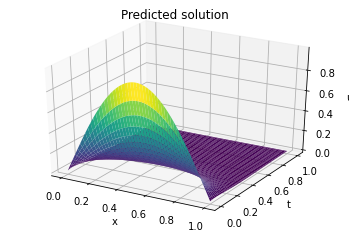

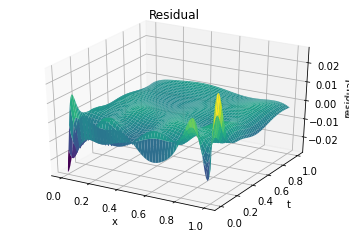

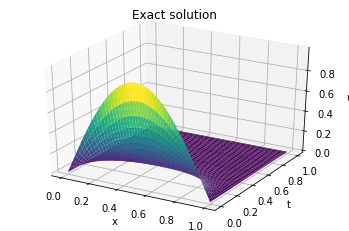

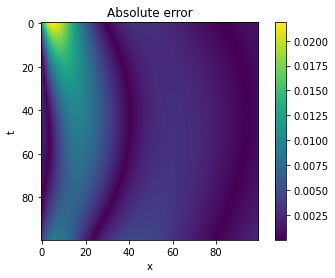

In [8]:
pinn.load_state_dict(torch.load(path_to_save))
pinn.eval()

res = 100
t = torch.linspace(0, 1, res).reshape(-1)
x = torch.linspace(0, 1, res).reshape(-1)
X, T = torch.meshgrid(x, t)
X = X.to(device).reshape(-1, 1)
T = T.to(device).reshape(-1, 1)

print(X.shape, T.shape)
U_pred, residuals = pinn(X, T)
U_pred = U_pred.cpu().detach().numpy().reshape(res, res)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.reshape(res, res).cpu(), T.reshape(res, res).cpu(), U_pred, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('Predicted solution')
plt.show()

#make a 3D plot of the residual

residuals = residuals.cpu().detach().numpy().reshape(res, res)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.reshape(res, res).cpu(), T.reshape(res, res).cpu(), residuals, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('residual')
plt.title('Residual')
plt.show()

# make a 3D plot of the exact solution

U_exact = heat_eqn_exact_solution(X.cpu().detach().numpy().reshape(res, res), T.cpu().detach().numpy().reshape(res, res))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.reshape(res, res).cpu(), T.reshape(res, res).cpu(), U_exact, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('Exact solution')
plt.show()

# make a heat plot of the absolute error

error = np.abs(U_exact - U_pred)

plt.imshow(error, cmap='viridis')
plt.colorbar()
plt.title('Absolute error')
plt.xlabel('x')
plt.ylabel('t')
plt.show()